Kernel to use here : *base (Python3.9.13)*

**TO DO :**
- Reprendre les analyses d'Alice. Comment sont générés les QT de la figure 
- 2ème analyse test : pour 1 objet visité, plotter la trajectoire de chaque QT fait autour de cet objet. Le début de la trajectoire doit se trouver au centre du graphique. Tous les QT doivent donc début au même centre. A faire d'abord pour les 10 premiers objets visités.
- 3ème analyse test : plotter la distribution des vitesses des QT en fonction du temps et ce pour chaque objet visité. 
- Une fois qu'on obtient les analyses voulues, passer ce qui est possible en fonction (facilitera l'incorporation dans le fichier MouseTache + accélère le processus d'analyse)
- Régler les échelles de chaque graphique
- Créer une seule figure avec toutes les analyses pour chaque objet. A redimensionner correctement à la fin. 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from scipy.ndimage import gaussian_filter as smooth
from own_Functions_05_4 import *
from median_thomas import *
import gc
from IPython.display import clear_output

#Intialize the value of some variables and define some important global variables
REMAINING_REWARDS = False # if true, indicate the number of reward available on an object when the mouse starts to go around

MINIMAL_DURATION_STOP = 0.1 #if a stop is shorter than this, merges the two epochs bordering it
MINIMAL_DURATION_EPOCH = 0.3 #minimal duration of an epoch to be considerd
TRAPEZE_SIZE = 35 #how much to extend outside of the objects to detect the trajectories
Resolution = 512,512 #variable which store the size of the experimental field in pixels
true_sigma = 1 #the sigma used for the remaining of the analysis
true_cut_speed = 7 #value to be used for the remaining of the analysis
true_ecart_angle = 1 #if a change is made, must change timeofframes

## Tests : plot the trajectories of QT from Alice's analysis

#### First : plot the trajectory around the first visited object, 1 second before the animal enters in it and 1 second after it left
#### Done for the 10 first visited objects

In [5]:
#Folder_path = '/home/david/MyLocalData/Maud/' #Path for Linux
Folder_path = 'C:\\Users\\mauds\\Documents\\WORKING_FROM_HOME\\SampleDatas_Batch6\\' #Path for Windows
mouseName = 'MOU4437'
session = 'MOU4437_20240313-1144'

In [6]:
# Tests for turns_df 

csv_turns_path = Folder_path + mouseName + '/' + session + '/' + session + '_turnsinfo.csv'
turns_df = pd.read_csv(csv_turns_path)
#turns_df=turns_df.loc[turns_df["time"]>15]
print(turns_df)

        time  framenumber  xposition  yposition currentPatch previousTrapeze  \
0      1.904           10        439        235           NE               S   
1      5.030           88        332        201           NE               W   
2      5.189           92        326        200           NE               S   
3      6.590          127        300        244           NE               W   
4     12.672          279        318        187           NE               S   
..       ...          ...        ...        ...          ...             ...   
674  711.526        17741        404        327           SE               E   
675  712.808        17773        412        203           NE               S   
676  713.646        17794        406        111           NE               E   
677  714.408        17813        305        105           NE               N   
678  715.527        17841        302        242           NE               W   

    currentTrapeze  turnDirection ongoi

In [7]:
# Création d'un dataframe pour plotter la trajectoire de chaque objet 

# turns_df = dataframe du tableur "turnsinfos" généré à la fin des sessions
# df = dataframe qui contient, à chaque fois que la souris visite un objet, quel objet est visité + à quel moment elle a commencé son premier turn + le temps du dernier QT

csv_turns_path = Folder_path + mouseName + '/' + session + '/' + session + '_turnsinfo.csv'
turns_df = pd.read_csv(csv_turns_path)
#turns_df=turns_df.loc[turns_df["time"]>15]

objets_visites = []
temps_entree = []
nb_QT = []
temps_sortie = []
current_patch = None

for index, row in turns_df.iterrows():
    # Si c'est la première ligne ou si le current_patch a changé
    if index == 0 or row['currentPatch'] != turns_df.iloc[index - 1]['currentPatch']:

        # Sauvegarde du currentPatch dans la liste des objets visités
        objets_visites.append(row['currentPatch'])
        
        # Sauvegarde du temps d'entrée
        temps_entree.append(row['time'])
        
        # Si ce n'est pas la première ligne, sauvegarder le temps de sortie précédent
        if index != 0:
            temps_sortie.append(turns_df.iloc[index - 1]['time'])
            nb_QT.append(turns_df.iloc[index - 1]['nberOfConsecRewards'])

# Ajouter le temps de sortie pour la dernière ligne
if not turns_df.empty:
    temps_sortie.append(turns_df.iloc[-1]['time'])
    nb_QT.append(turns_df.iloc[-1]['nberOfConsecRewards'])

# Création du DataFrame à partir des listes
df = pd.DataFrame({
    "Objet visité": objets_visites,
    "temps d'entrée": temps_entree,
    "temps de sortie": temps_sortie,
    "nb rewards": nb_QT
    })

df=df.loc[df["temps d'entrée"]>15]
print(df)


    Objet visité  temps d'entrée  temps de sortie  nb rewards
2             SW          16.953           20.319           1
3             SE          21.035           22.517           4
4             NE          24.078           26.559           0
5             NW          27.879           30.362           0
6             NE          31.283           33.445           0
..           ...             ...              ...         ...
174           SW         673.825          675.386          14
175           NW         675.666          675.666          15
176           SW         679.588          688.314          17
177           SE         704.001          711.526          20
178           NE         712.808          715.527           0

[177 rows x 4 columns]


In [8]:
#trajectoire autour du premier objet visité et/ou des suivants 

#traj_df = dataframe qui contient les mêmes données que centroidTXY avec les 15 premières secondes en moins 

csv_centroid_path=Folder_path + mouseName + '/' + session + '/' + session + '_centroidTXY.csv'

traj_df=pd.read_csv(csv_centroid_path)
traj_df=traj_df.dropna()
traj_df=traj_df.loc[traj_df['time'] >15]
traj_df=traj_df[traj_df['xposition'].between(1,500) & traj_df['yposition'].between(1,500)]

xpositions=traj_df['xposition'].to_numpy()
ypositions=traj_df['yposition'].to_numpy()
        
distances=np.array([((((xpositions[i]-xpositions[i-1])**2)+((ypositions[i]-ypositions[i-1])**2))**0.5) for i in range(1,len(ypositions))])
resolution=resolution = 512,512

traj_df['yposition'] = resolution[1] - traj_df['yposition']

distances = distances *(0.84/resolution[0]) #convert distance to m with apparatus length = 84 cm
totaldistance=np.sum(distances)
averagerunningspeed=np.sum(distances)/(12*60)
timeofframes=traj_df['time'].to_numpy()
timebeweenframe=np.diff(timeofframes)
speeds=np.divide(distances,timebeweenframe)

In [9]:
def filter_trajectory_around_time(traj_df, time_start, time_end, time_margin=1): 
    '''Cette fonction sert à ajouter un temps défini à mon temps d'entrée et de sortie 
    pour obtenir la trajectoire avant et après un QT
    Return un dataframe filtré'''
    traj_df_filtered = traj_df[(traj_df['time'] >= (time_start - time_margin)) & (traj_df['time'] <= (time_end + time_margin))]
    return traj_df_filtered

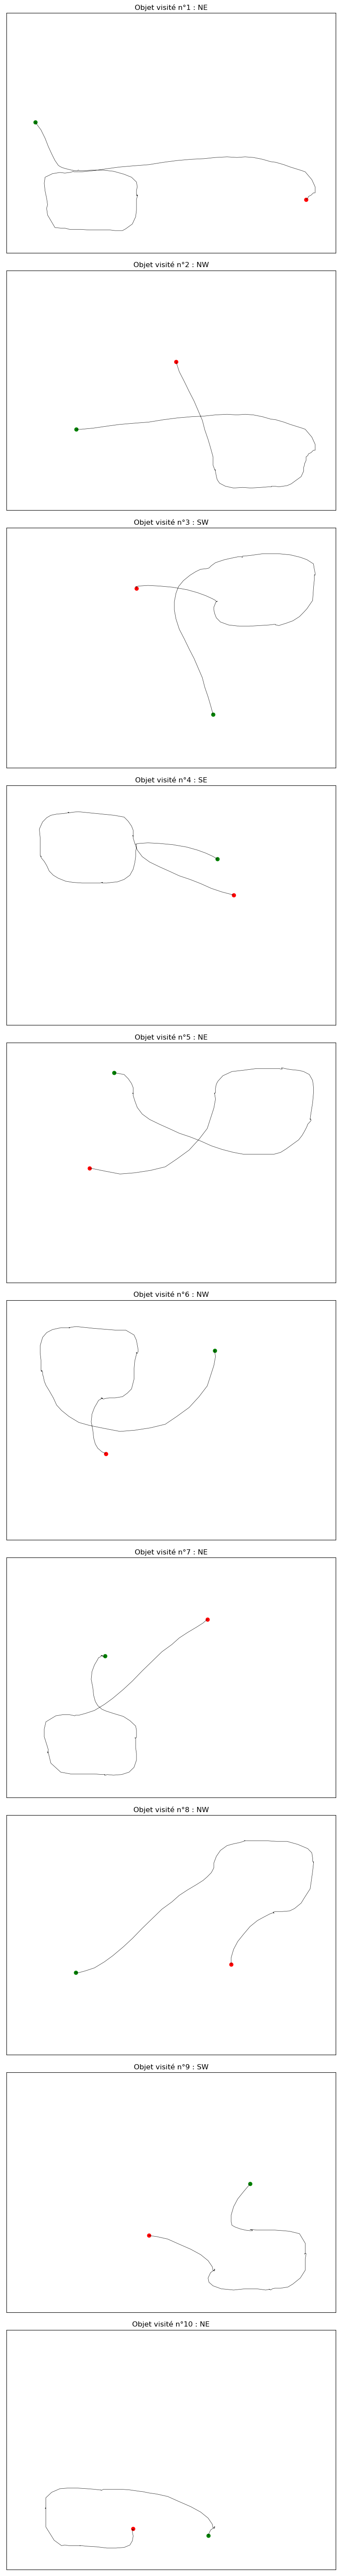

In [10]:
# Limite de la taille du cadre
frame_size = 270
n=min(len(objets_visites), 10)

# Création de sous-graphiques pour chaque objet visité
fig, axs = plt.subplots(n, figsize=(8, 6 * n))

# Itération sur les objets visités
for i, objet_visite in enumerate(objets_visites[:n]):
    # Filtrage des données de trajectoire pour l'objet visité actuel
    #traj_df_objet = traj_df[(traj_df['time'] >= df.iloc[i]["temps d'entrée"]) & (traj_df['time'] <= df.iloc[i]["temps de sortie"])]
    traj_df_objet = filter_trajectory_around_time(traj_df, df.iloc[i]["temps d'entrée"], df.iloc[i]["temps de sortie"])

    # Calcul des coordonnées de début et de fin de la trajectoire
    x_debut = traj_df_objet['xposition'].iloc[0]
    y_debut = traj_df_objet['yposition'].iloc[0]
    x_fin = traj_df_objet['xposition'].iloc[-1]
    y_fin = traj_df_objet['yposition'].iloc[-1]

    # Calcul de la plage d'affichage des axes pour centrer le début de la trajectoire
    #x_lim_min = max(0, x_debut - frame_size/2)
    #x_lim_max = min(500, x_debut + frame_size/2)
    #y_lim_min = max(0, y_debut - frame_size/2)
    #y_lim_max = min(500, y_debut + frame_size/2)

    # Création du graphique de trajectoire
    axs[i].plot(traj_df_objet['xposition'], traj_df_objet['yposition'], linewidth=0.5, c='k')
    axs[i].scatter(x_debut, y_debut, color='green', label='Début')  # Point vert au début
    axs[i].scatter(x_fin, y_fin, color='red', label='Fin')          # Point rouge à la fin
    #axs[i].set_xlim(x_lim_min, x_lim_max) # Etait utilisé pour centrer la trajectoire
    #axs[i].set_ylim(y_lim_min, y_lim_max) # Etait utilisé pour centrer la trajectoire
    axs[i].set_xlim(50, 450)
    axs[i].set_ylim(50, 450)
    axs[i].set_title(f"Objet visité n°{i+1} : {objet_visite}")

    # Supprimer les graduations sur les axes X et Y
    axs[i].set_xticks([])
    axs[i].set_yticks([])

# Affichage des graphiques
plt.tight_layout()
plt.show()

In [20]:
#Test print traj_df
print(traj_df)

          time  xposition  yposition
337     15.032       88.0      336.0
338     15.074       88.0      336.0
339     15.113       88.0      336.0
340     15.153       88.0      337.0
341     15.194       87.0      339.0
...        ...        ...        ...
17948  719.847      462.0      245.0
17949  719.890      462.0      245.0
17950  719.930      462.0      245.0
17951  719.970      462.0      245.0
17952  720.009      462.0      245.0

[17616 rows x 3 columns]


#### Second : plot the trajectory of every QT individually around the visited objects
##### Every trajectory must start in the middle of a graph, the graph is centered around each object
##### Also done for the 10 first visited objects